In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Năm 3/HPC/HPC - Nhóm 8/HPC - Đồ án"

/content/drive/MyDrive/Năm 3/HPC/HPC - Nhóm 8/HPC - Đồ án


In [ ]:
!pwd

/content/drive/MyDrive/Năm 3/HPC/HPC - Nhóm 8/HPC - Đồ án


# **Libraries**

In [ ]:
!pip install holidays
!pip install torchinfo

In [ ]:
!pip install --upgrade torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
import os
import time
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import pickle

# **Configuration**

In [ ]:
file_path = './data/raw/ankhanh_measurements.csv'

features_type='M'
input_size = 72
label_size = 24
offset = 24
train_size = 0.70
val_size = 0.15
batch_size = 32
stride = 6         # Sliding window stride

num_epochs = 50
patience = 20
learning_rate = 0.001
hidden_size = 32
num_layers = 2
plot_dir = './plots'
weight_dir = './weights'
sub_dir = 'multi2multi'
data_dir = './data'

# **Data Loader**

Thêm các biến thời gian

Log transformation

In [ ]:
class TimeSeriesDataLoader:
    def __init__(self, file_path, input_size, label_size, offset, train_size, val_size,
                 date_column=None, target_name=None, features_type="M", batch_size=64,
                 nan_threshold=0.00, stride=1):

        self.input_size = input_size
        self.label_size = label_size
        self.offset = offset if offset > label_size else label_size
        self.train_size = train_size
        self.val_size = val_size
        self.target_name = target_name
        self.features_type = features_type
        self.batch_size = batch_size
        self.nan_threshold = nan_threshold
        self.stride = stride

        # Load and preprocess data
        self.df = pd.read_csv(file_path)

        # Đổi tên cột: loại bỏ đơn vị
        self.df.rename(columns={
            "co µg/m³": "co",
            "pm25 µg/m³": "pm25",
            "no2 µg/m³": "no2",
            "pm10 µg/m³": "pm10"
        }, inplace=True)
        self.df.drop(columns=['datetimeTo_utc', 'datetimeTo_local', 'datetimeFrom_utc', 'pm10'], inplace=True)
        self.df['datetimeFrom_local'] = pd.to_datetime(self.df['datetimeFrom_local'])
        self.df = self.df.set_index('datetimeFrom_local')

        # Tạo lại dãy thời gian liên tục
        full_index = pd.date_range(start=self.df.index.min(), end=self.df.index.max(), freq='1h')
        self.df = self.df.reindex(full_index)

        # Thêm time-based features
        vn_holidays = holidays.Vietnam()
        self.df['hour'] = self.df.index.hour
        self.df['dayofweek'] = self.df.index.dayofweek
        self.df['is_holiday'] = self.df.index.normalize().isin(vn_holidays)

        self.df['hour_sin'] = np.sin(2 * np.pi * self.df['hour'] / 24)
        self.df['hour_cos'] = np.cos(2 * np.pi * self.df['hour'] / 24)
        self.df['dayofweek_sin'] = np.sin(2 * np.pi * self.df['dayofweek'] / 7)
        self.df['dayofweek_cos'] = np.cos(2 * np.pi * self.df['dayofweek'] / 7)
        self.df['is_holiday'] = self.df['is_holiday'].astype(int)

        self.df.drop(columns=['hour', 'dayofweek'], inplace=True)


        # Extract valid sequences
        self.valid_sequences = self._extract_valid_sequences()

        if features_type == 'S':
            self.in_variable = 1
            self.out_variable = 1
        elif features_type == 'M':
            self.in_variable = len(self.df.columns)
            # self.out_variable = len(self.df.columns)
            self.out_variable = 3
        elif features_type == 'MS':
            self.in_variable = len(self.df.columns)
            self.out_variable = 1
        else:
            raise ValueError("Invalid features_type. Choose from 'S', 'M', 'MS'.")

        # print(self.df.head())

        # Các cột cần transform
        self.cols_to_transform = ["co", "pm25", "no2"]

         # Apply log transform ONLY to the specified columns
        # Note: No scaling is applied in this version
        transformed_df = self.df.copy()

        # Apply log1p transform only to the specified columns
        transformed_df[self.cols_to_transform] = np.log1p(transformed_df[self.cols_to_transform])

        # Replace the original columns with log-transformed values in the main DataFrame
        self.df[self.cols_to_transform] = transformed_df[self.cols_to_transform]

        # Lưu file data đã được xử lý
        os.makedirs(os.path.join(data_dir, 'processed'), exist_ok=True)
        self.df.to_csv(os.path.join(data_dir, 'processed/processed_data.csv'))

        self.X_train, self.y_train = self._create_dataset(0, int(train_size * len(self.valid_sequences)))
        print(f'X_train.shape = {self.X_train.shape}')
        print(f'y_train.shape = {self.y_train.shape}')
        # print("Y train", self.y_train)
        self.X_val, self.y_val = self._create_dataset(int(train_size * len(self.valid_sequences)),
                                                      int((train_size + val_size) * len(self.valid_sequences)))
        print(f'X_val.shape = {self.X_val.shape}')
        print(f'y_val.shape = {self.y_val.shape}')
        # print("Y val", self.y_val)
        self.X_test, self.y_test = self._create_dataset(int((train_size + val_size) * len(self.valid_sequences)), None)
        print(f'X_test.shape = {self.X_test.shape}')
        print(f'y_test.shape = {self.y_test.shape}')
        # print("Y test", self.y_test)

        self.train_loader = self._create_dataloader(self.X_train, self.y_train)
        self.val_loader = self._create_dataloader(self.X_val, self.y_val)
        self.test_loader = self._create_dataloader(self.X_test, self.y_test)

    def _extract_valid_sequences(self):
        total_len = len(self.df)
        seq_len = self.input_size + self.offset + self.label_size
        valid_chunks = []

        for i in range(0, total_len - seq_len, self.stride):
            window = self.df.iloc[i:i + seq_len]
            nan_ratio = window.isna().sum().sum() / (seq_len * len(self.df.columns))
            if nan_ratio <= self.nan_threshold:
                valid_chunks.append(i)

        return valid_chunks

    def _create_dataset(self, start_idx, end_idx):
        if end_idx is None:
            end_idx = len(self.valid_sequences)

        features, labels = [], []

        for i in self.valid_sequences[start_idx:end_idx]:
            feat_start = i
            feat_end = feat_start + self.input_size
            label_start = feat_end + self.offset
            label_end = label_start + self.label_size

            if self.features_type == 'S':
                feature = self.df[[self.target_name]].iloc[feat_start:feat_end]
                label = self.df[[self.target_name]].iloc[label_start:label_end]
            elif self.features_type == 'M':
                feature = self.df.iloc[feat_start:feat_end]
                ## Thứ tự label: pm25, co, no2
                label = self.df.iloc[label_start:label_end][['pm25', 'co', 'no2']]
            elif self.features_type == 'MS':
                feature = self.df.iloc[feat_start:feat_end]
                label = self.df[[self.target_name]].iloc[label_start:label_end]
            else:
                raise ValueError("Invalid features_type.")

            features.append(feature.to_numpy())
            labels.append(label.to_numpy())

        return np.array(features), np.array(labels)

    def _create_dataloader(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)


In [ ]:
data_loader = TimeSeriesDataLoader(file_path,
                                            input_size=input_size,
                                            label_size=label_size,
                                            offset=offset,
                                            train_size=train_size,
                                            val_size=val_size,
                                            features_type=features_type,
                                            batch_size=batch_size,
                                            stride=stride)

X_train.shape = (522, 72, 8)
y_train.shape = (522, 24, 3)
X_val.shape = (112, 72, 8)
y_val.shape = (112, 24, 3)
X_test.shape = (113, 72, 8)
y_test.shape = (113, 24, 3)


In [ ]:
# Display features and label.
train_features, train_labels = next(iter(data_loader.train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 72, 8])
Labels batch shape: torch.Size([32, 24, 3])


# **Model Manager**

In [ ]:
class ModelManager:
    def __init__(self, model, train_loader, val_loader=None, lr=0.001, patience=100):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    def train(self, num_epochs, save_dir='.'):
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()
            total_train_loss = 0

            for inputs, targets in self.train_loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_train_loss += loss.item()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            avg_train_loss = total_train_loss / len(self.train_loader)
            val_loss = self.evaluate(self.val_loader) if self.val_loader is not None else 0.0

            train_losses.append(avg_train_loss)
            val_losses.append(val_loss)

            if self.early_stopping(val_loss, save_path):
                print(f"Early stopping at epoch {epoch + 1}")
                break

            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'time: {int(time.time() - start_time)}s, '
                  f'loss: {avg_train_loss:.4f}, '
                  f'val_loss: {val_loss:.4f}')

        # Load lại best model
        self.load_model(save_path)

        # Plot loss
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train vs Validation Loss')
        plt.legend()
        plt.grid(True)
        plot_path = os.path.join(save_dir, f'{self.model.__class__.__name__}_loss_plot.png')
        plt.savefig(plot_path)
        plt.show()
        plt.close()

        # # 🔽 Thêm phần này để lưu mô hình dạng pickle
        # pickle_path = os.path.join(save_dir, f'{self.model.__class__.__name__}.pkl')
        # with open(pickle_path, 'wb') as f:
        #     pickle.dump(self.model, f)
        # print(f"Saved full model (with architecture) to {pickle_path}")



    def evaluate(self, loader):
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        return avg_loss


    def calc_metrics(self, loader):
        self.model.eval()
        total_loss = 0

        all_targets = []
        all_outputs = []

        with torch.no_grad():
            for inputs, targets in loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()

                all_targets.append(targets.cpu())
                all_outputs.append(outputs.cpu())

        # Tính MAE trung bình (criterion)
        avg_mae_criterion = total_loss / len(loader)

        # Gộp các batch lại
        all_targets = torch.cat(all_targets, dim=0)
        all_outputs = torch.cat(all_outputs, dim=0)

        # Metrics trên dữ liệu log1p
        actual_mae = torch.mean(torch.abs(all_outputs - all_targets)).item()
        rmse = torch.sqrt(torch.mean((all_outputs - all_targets) ** 2)).item()

        ss_res = torch.sum((all_targets - all_outputs) ** 2)
        ss_tot = torch.sum((all_targets - torch.mean(all_targets)) ** 2)
        r2 = (1 - ss_res / ss_tot).item() if ss_tot != 0 else float('nan')

        # -----------------------------------------------
        # Inverse log1p
        all_targets_inv = torch.expm1(all_targets)
        all_outputs_inv = torch.expm1(all_outputs)

        # Metrics sau inverse log1p (trong đơn vị gốc)
        mae_inv = torch.mean(torch.abs(all_outputs_inv - all_targets_inv)).item()
        rmse_inv = torch.sqrt(torch.mean((all_outputs_inv - all_targets_inv) ** 2)).item()


        ss_res_inv = torch.sum((all_targets_inv - all_outputs_inv) ** 2)
        ss_tot_inv = torch.sum((all_targets_inv - torch.mean(all_targets_inv)) ** 2)
        r2_inv = (1 - ss_res_inv / ss_tot_inv).item() if ss_tot_inv != 0 else float('nan')

        # -----------------------------------------------

        return {
            # Metric trong không gian log1p (dành cho so sánh huấn luyện)
            'MAE (log1p)': actual_mae,
            'RMSE (log1p)': rmse,
            'R2 (log1p)': r2,

            # Metric sau inverse log1p
            'MAE (original)': mae_inv,
            'RMSE (original)': rmse_inv,
            'R2 (original)': r2_inv
        }


    def early_stopping(self, val_loss, save_path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

    def load_model(self, load_path):
        self.model.load_state_dict(torch.load(load_path))
        print(f'Model loaded from {load_path}')

    def predict(self, input_data):
        self.model.eval()   # Set the model to evaluation mode

        if isinstance(input_data, DataLoader):
            # If input_data is a DataLoader, iterate through batches and concatenate predictions
            predictions = []
            with torch.no_grad():
                for inputs, _ in input_data:
                    outputs = self.model(inputs)
                    predictions.append(outputs)
            predictions = torch.cat(predictions, dim=0)
        else:
            # Assume input_data is a single input tensor
            with torch.no_grad():
                predictions = self.model(input_data.unsqueeze(0))

        return predictions

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None:
            feature_names = [f'Feature {i + 1}' for i in range(y.shape[2])]

        if num_elements is not None:
            y = y[:num_elements]
            yhat = yhat[:num_elements]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10, 5))
            plt.plot(y[:, :, feature_index].flatten(), label='y', linestyle='-', linewidth=0.7)
            plt.plot(yhat[:, :, feature_index].flatten(), label='y_hat', linestyle='--', linewidth=1)
            plt.title(feature_name)
            plt.xlabel('Time Step')
            plt.ylabel('Values')
            plt.legend()

            if save_plots:
                # Create the save directory if it doesn’t exist
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)
                # Save the plot
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name}.png')
                plt.savefig(save_path)

            plt.show()
            plt.close()  # Close the plot to avoid overlapping in saved images


# **RNN**

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # RNN Layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0  # Dropout giữa các layer RNN nếu num_layers > 1
        )

        # Batch Normalization
        self.bn = nn.BatchNorm1d(hidden_size)

        # Dropout Layer
        self.dropout = nn.Dropout(0.3)

        # Improved Output Layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, output_size * ahead)
        )

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  # out shape: (batch, seq_len, hidden_size)

        # Chỉ lấy hidden state ở bước thời gian cuối cùng
        out = out[:, -1, :]  # shape: (batch, hidden_size)

        # Áp dụng BatchNorm và Dropout
        out = self.bn(out)
        out = self.dropout(out)

        # Dự đoán đầu ra
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [28]:
# Khởi tạo mô hình
RNN_model = RNN(
    input_size=data_loader.in_variable,
    hidden_size=hidden_size,
    output_size=data_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers,
)

print("RNN Model Summary")
summary(RNN_model)

RNN Model Summary


Layer (type:depth-idx)                   Param #
RNN                                      --
├─RNN: 1-1                               3,456
├─BatchNorm1d: 1-2                       64
├─Dropout: 1-3                           --
├─Sequential: 1-4                        --
│    └─Linear: 2-1                       1,056
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       2,376
Total params: 6,952
Trainable params: 6,952
Non-trainable params: 0

Model saved to ./weights/multi2multi/best-RNN.pth
Epoch [1/50], time: 0s, loss: 4.4387, val_loss: 4.2806
Model saved to ./weights/multi2multi/best-RNN.pth
Epoch [2/50], time: 0s, loss: 4.2463, val_loss: 4.1920
Model saved to ./weights/multi2multi/best-RNN.pth
Epoch [3/50], time: 0s, loss: 3.9274, val_loss: 3.7700
Model saved to ./weights/multi2multi/best-RNN.pth
Epoch [4/50], time: 0s, loss: 3.3940, val_loss: 2.4831
Model saved to ./weights/multi2multi/best-RNN.pth
Epoch [5/50], time: 0s, loss: 2.5943, val_loss: 1.7087
Model saved to ./weights/multi2multi/best-RNN.pth
Epoch [6/50], time: 0s, loss: 2.1274, val_loss: 1.3672
Model saved to ./weights/multi2multi/best-RNN.pth
Epoch [7/50], time: 0s, loss: 1.6222, val_loss: 0.9664
Model saved to ./weights/multi2multi/best-RNN.pth
Epoch [8/50], time: 0s, loss: 1.4831, val_loss: 0.7702
Model saved to ./weights/multi2multi/best-RNN.pth
Epoch [9/50], time: 0s, loss: 1.3612, val_loss: 0.5943
Model saved to ./weights/multi2multi/best-RNN.pth
Epoch

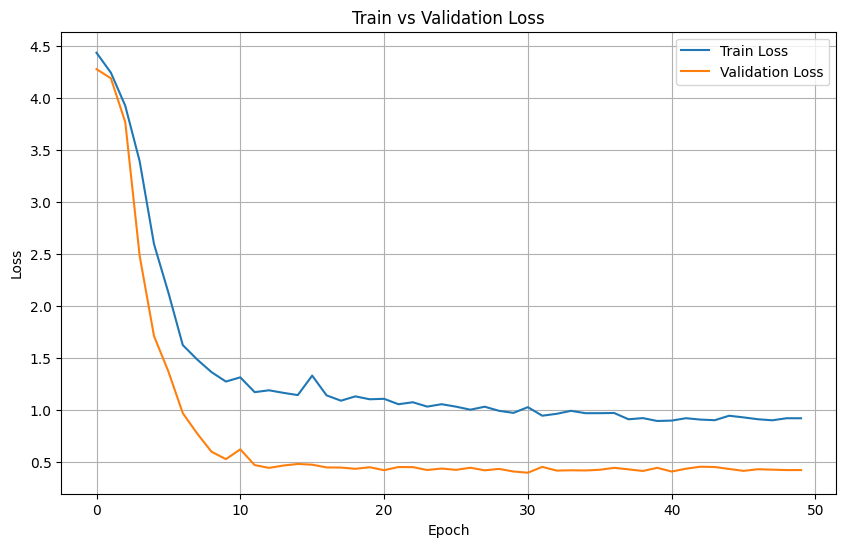

In [29]:
# Khởi tạo quản lý mô hình
RNN_manager = ModelManager(
    model=RNN_model,
    train_loader=data_loader.train_loader,
    val_loader=data_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

# Huấn luyện mô hình
RNN_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

Load model weight để dự đoán

In [ ]:
# Định nghĩa lại mô hình
RNN_model = RNN(
    input_size=data_loader.in_variable,
    hidden_size=hidden_size,
    output_size=data_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers,
)

# Khởi tạo quản lý mô hình
RNN_manager = ModelManager(
    model=RNN_model,
    train_loader=data_loader.train_loader,
    val_loader=data_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

RNN_manager.load_model(os.path.join(weight_dir, sub_dir, 'best-RNN.pth'))

Model loaded from ./weights/multi2multi/best-RNN.pth


In [ ]:
RNN_manager.calc_metrics(loader=data_loader.test_loader)

{'MAE (log1p)': 0.4605671763420105,
 'RMSE (log1p)': 0.616008996963501,
 'R2 (log1p)': 0.793465256690979,
 'MAE (original)': 79.27495574951172,
 'RMSE (original)': 169.81201171875,
 'R2 (original)': 0.6110309362411499}

<ipython-input-14-eb3d57c29b18>:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  yhat = np.expm1(yhat)


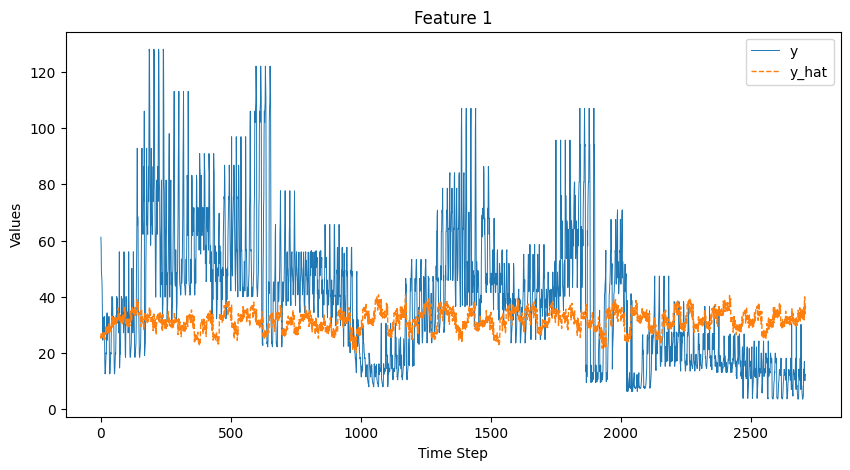

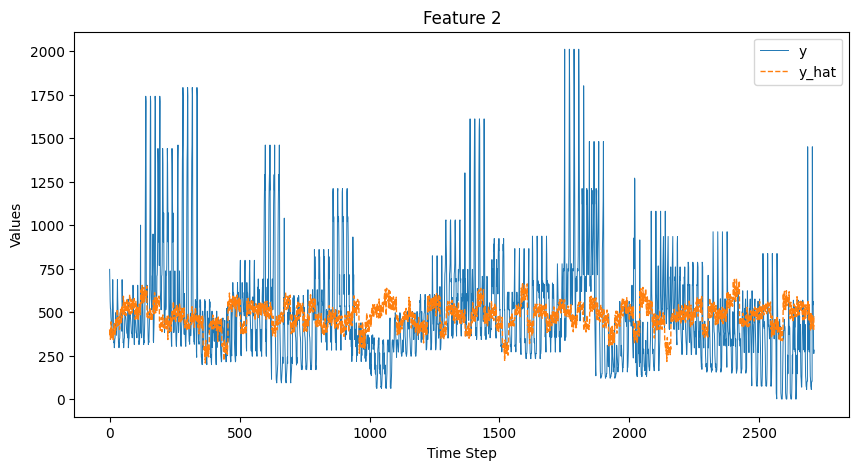

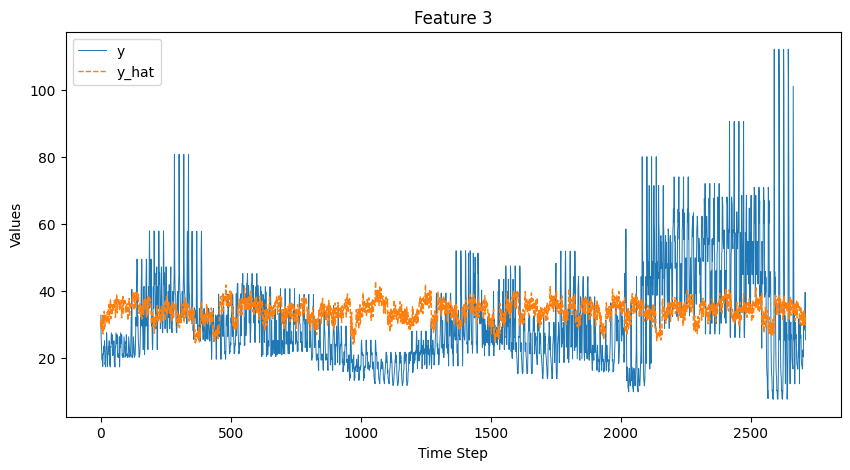

In [ ]:
yhat = RNN_manager.predict(data_loader.test_loader)
y = data_loader.y_test

# Inverse log transform
y = np.expm1(y)
yhat = np.expm1(yhat)

RNN_manager.plot(y, yhat, save_dir=plot_dir)

# **LSTM**

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        # Batch Normalization
        self.bn = nn.BatchNorm1d(hidden_size)

        # Dropout Layer
        self.dropout = nn.Dropout(0.3)

        # Output Layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, output_size * ahead)
        )

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch, seq_len, hidden_size)

        # Take the output from the last time step
        out = out[:, -1, :]  # shape: (batch, hidden_size)

        # BatchNorm + Dropout
        out = self.bn(out)
        out = self.dropout(out)

        # Fully connected prediction
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [ ]:
print(data_loader.in_variable)
print(hidden_size)
print(data_loader.out_variable)
print(label_size)
print(num_layers)

8
32
3
24
2


In [ ]:
# Khởi tạo mô hình
LSTM_model = LSTM(
    input_size=data_loader.in_variable,
    hidden_size=hidden_size,
    output_size=data_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers,
)

print("Model Summary")
summary(LSTM_model)

Model Summary


Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              13,824
├─BatchNorm1d: 1-2                       64
├─Dropout: 1-3                           --
├─Sequential: 1-4                        --
│    └─Linear: 2-1                       1,056
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       2,376
Total params: 17,320
Trainable params: 17,320
Non-trainable params: 0

Model saved to ./weights/multi2multi/best-LSTM.pth
Epoch [1/50], time: 1s, loss: 4.3974, val_loss: 4.3093
Model saved to ./weights/multi2multi/best-LSTM.pth
Epoch [2/50], time: 0s, loss: 4.1069, val_loss: 4.1206
Model saved to ./weights/multi2multi/best-LSTM.pth
Epoch [3/50], time: 0s, loss: 3.5587, val_loss: 2.6316
Model saved to ./weights/multi2multi/best-LSTM.pth
Epoch [4/50], time: 0s, loss: 2.6685, val_loss: 1.7345
Model saved to ./weights/multi2multi/best-LSTM.pth
Epoch [5/50], time: 0s, loss: 1.8619, val_loss: 1.1613
Model saved to ./weights/multi2multi/best-LSTM.pth
Epoch [6/50], time: 0s, loss: 1.5543, val_loss: 0.7523
Model saved to ./weights/multi2multi/best-LSTM.pth
Epoch [7/50], time: 0s, loss: 1.4271, val_loss: 0.6514
Model saved to ./weights/multi2multi/best-LSTM.pth
Epoch [8/50], time: 0s, loss: 1.2969, val_loss: 0.5501
Model saved to ./weights/multi2multi/best-LSTM.pth
Epoch [9/50], time: 0s, loss: 1.2868, val_loss: 0.4525
Epoch [10/50], time: 0s, loss: 1.3659, val_los

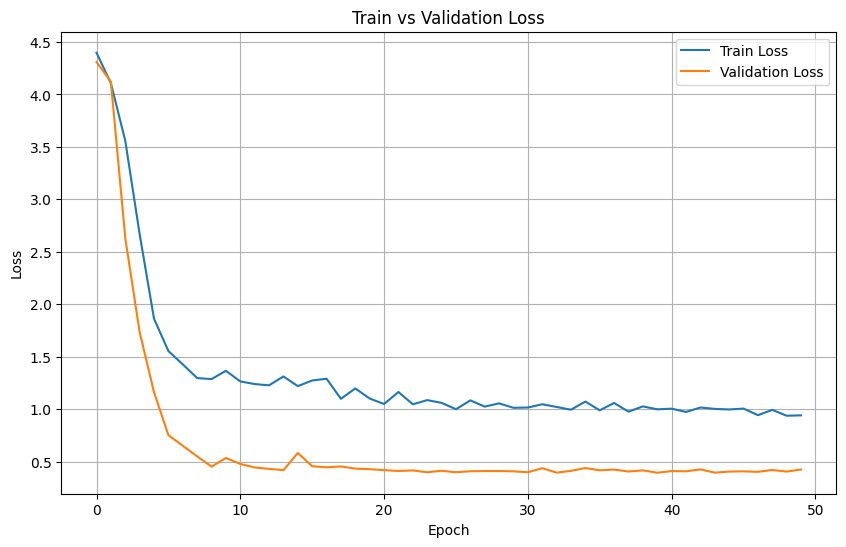

In [ ]:
# Khởi tạo quản lý mô hình
LSTM_manager = ModelManager(
    model=LSTM_model,
    train_loader=data_loader.train_loader,
    val_loader=data_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

# Huấn luyện mô hình
LSTM_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

In [ ]:
# Khởi tạo quản lý mô hình
LSTM_manager = ModelManager(
    model=LSTM_model,
    train_loader=data_loader.train_loader,
    val_loader=data_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

LSTM_manager.calc_metrics(loader=data_loader.test_loader)

{'MAE (log1p)': 0.47931742668151855,
 'RMSE (log1p)': 0.6310911178588867,
 'R2 (log1p)': 0.7832279801368713,
 'MAE (original)': 81.42102813720703,
 'RMSE (original)': 179.24769592285156,
 'R2 (original)': 0.5666034817695618}

<ipython-input-21-3feb0db8726c>:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  yhat = np.expm1(yhat)


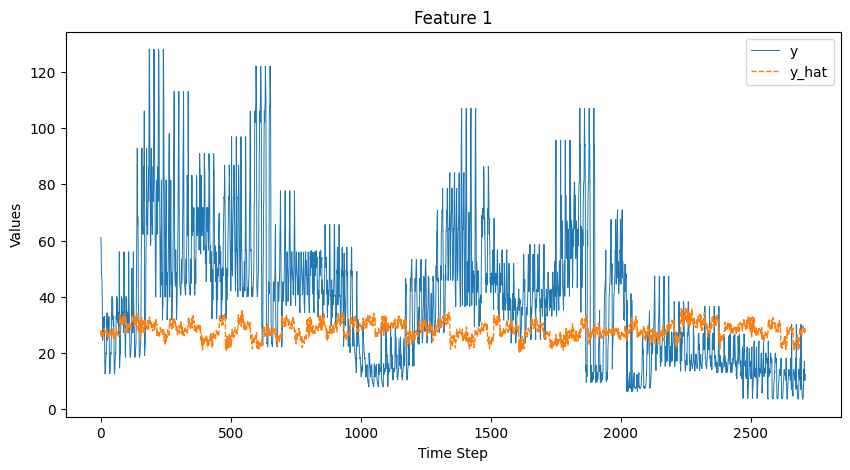

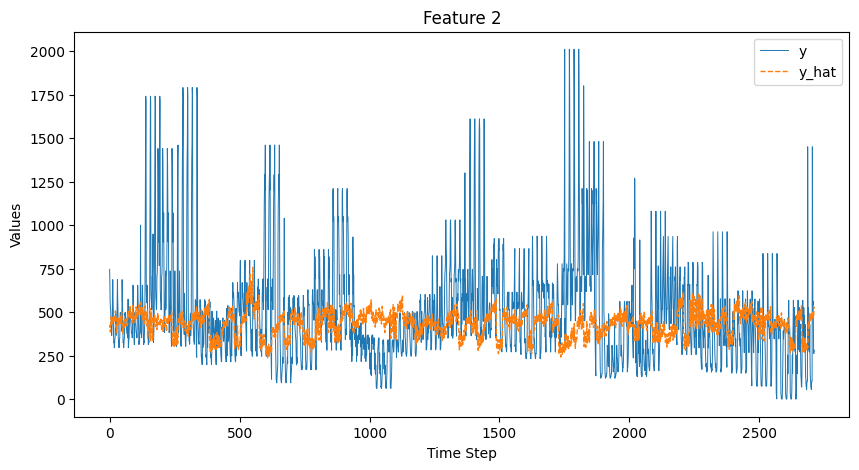

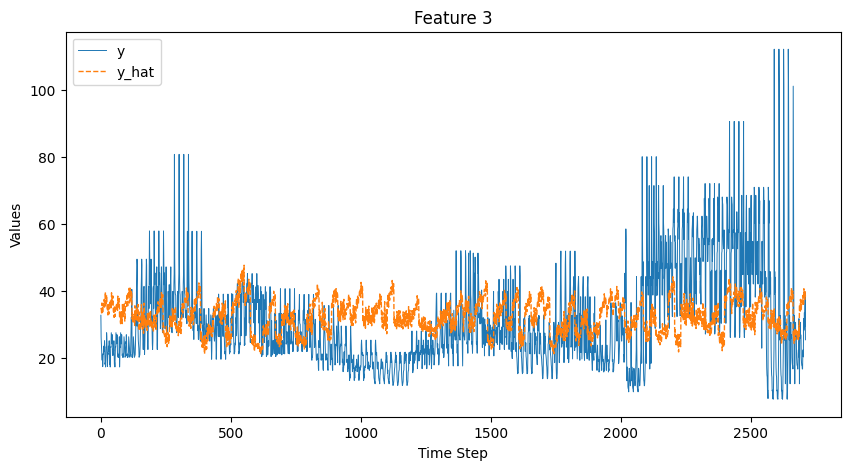

In [ ]:
yhat = LSTM_manager.predict(data_loader.test_loader)
y = data_loader.y_test

# Inverse log transform
y = np.expm1(y)
yhat = np.expm1(yhat)

LSTM_manager.plot(y, yhat, save_dir=plot_dir)

# **GRU**

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # GRU Layer
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        # Batch Normalization
        self.bn = nn.BatchNorm1d(hidden_size)

        # Dropout Layer
        self.dropout = nn.Dropout(0.3)

        # Output Layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, output_size * ahead)
        )

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out shape: (batch, seq_len, hidden_size)

        # Take the output from the last time step
        out = out[:, -1, :]  # shape: (batch, hidden_size)

        # BatchNorm + Dropout
        out = self.bn(out)
        out = self.dropout(out)

        # Fully connected prediction
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out


In [ ]:
# Khởi tạo mô hình
GRU_model = GRU(
    input_size=data_loader.in_variable,
    hidden_size=hidden_size,
    output_size=data_loader.out_variable,
    ahead=label_size,
    num_layers=num_layers,
)

print("GRU Model Summary")
summary(GRU_model)

GRU Model Summary


Layer (type:depth-idx)                   Param #
GRU                                      --
├─GRU: 1-1                               10,368
├─BatchNorm1d: 1-2                       64
├─Dropout: 1-3                           --
├─Sequential: 1-4                        --
│    └─Linear: 2-1                       1,056
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       2,376
Total params: 13,864
Trainable params: 13,864
Non-trainable params: 0

Model saved to ./weights/multi2multi/best-GRU.pth
Epoch [1/50], time: 1s, loss: 4.4601, val_loss: 4.3422
Model saved to ./weights/multi2multi/best-GRU.pth
Epoch [2/50], time: 1s, loss: 4.2524, val_loss: 4.1933
Model saved to ./weights/multi2multi/best-GRU.pth
Epoch [3/50], time: 1s, loss: 3.8707, val_loss: 3.5554
Model saved to ./weights/multi2multi/best-GRU.pth
Epoch [4/50], time: 1s, loss: 3.2428, val_loss: 2.2405
Model saved to ./weights/multi2multi/best-GRU.pth
Epoch [5/50], time: 1s, loss: 2.3875, val_loss: 1.6629
Model saved to ./weights/multi2multi/best-GRU.pth
Epoch [6/50], time: 1s, loss: 1.7649, val_loss: 1.1686
Model saved to ./weights/multi2multi/best-GRU.pth
Epoch [7/50], time: 1s, loss: 1.4938, val_loss: 0.7352
Model saved to ./weights/multi2multi/best-GRU.pth
Epoch [8/50], time: 1s, loss: 1.2945, val_loss: 0.6043
Model saved to ./weights/multi2multi/best-GRU.pth
Epoch [9/50], time: 1s, loss: 1.2771, val_loss: 0.5685
Model saved to ./weights/multi2multi/best-GRU.pth
Epoch

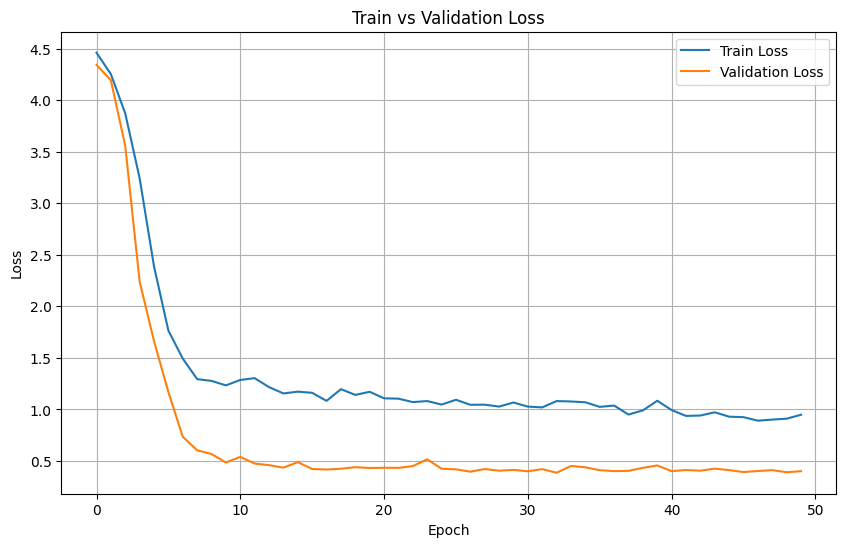

In [ ]:
# Khởi tạo quản lý mô hình
GRU_manager = ModelManager(
    model=GRU_model,
    train_loader=data_loader.train_loader,
    val_loader=data_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

# Huấn luyện mô hình
GRU_manager.train(
    num_epochs=num_epochs,
    save_dir=os.path.join(weight_dir, sub_dir)
)

In [ ]:
# Khởi tạo quản lý mô hình
GRU_manager = ModelManager(
    model=GRU_model,
    train_loader=data_loader.train_loader,
    val_loader=data_loader.val_loader,
    lr=learning_rate,
    patience=patience
)

GRU_manager.calc_metrics(loader=data_loader.test_loader)

{'MAE (log1p)': 0.4652138948440552,
 'RMSE (log1p)': 0.62143474817276,
 'R2 (log1p)': 0.7898109555244446,
 'MAE (original)': 80.54370880126953,
 'RMSE (original)': 174.371826171875,
 'R2 (original)': 0.5898611545562744}

<ipython-input-27-8314ff2ae6b9>:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  yhat = np.expm1(yhat)


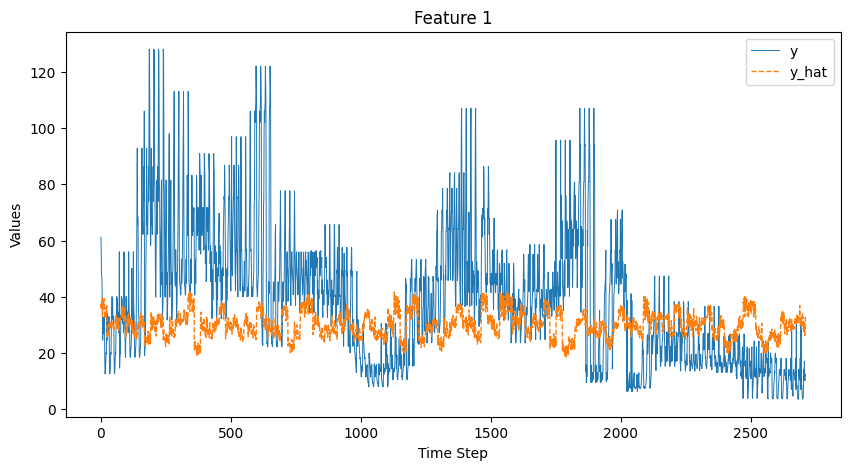

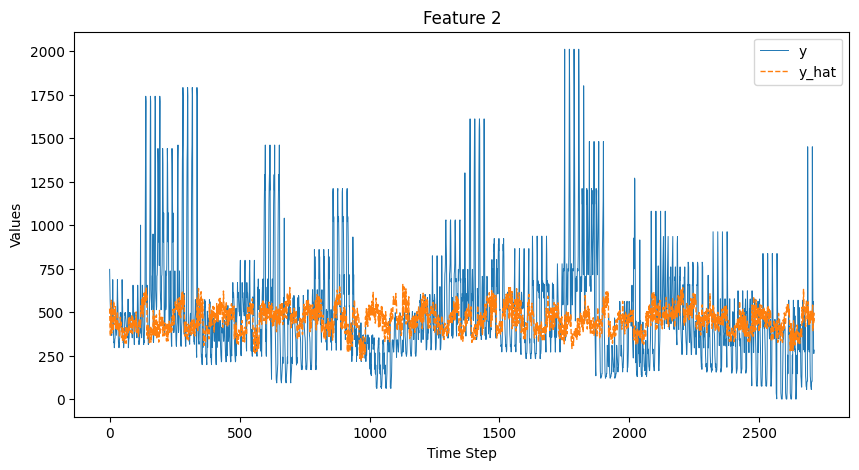

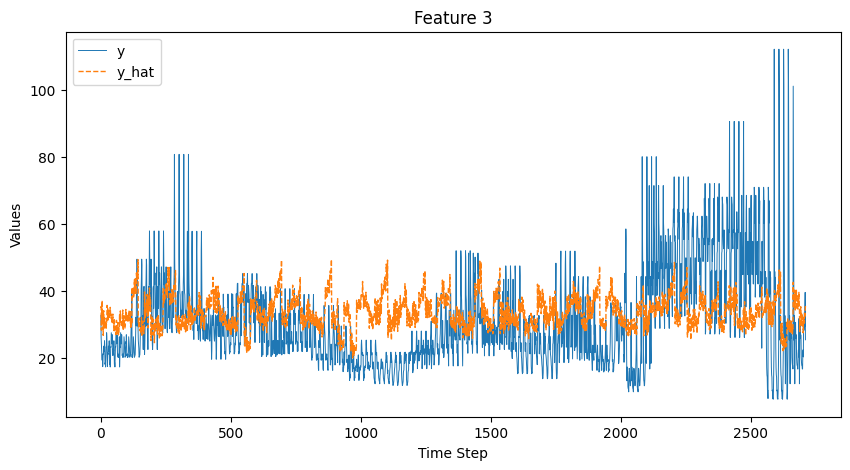

In [ ]:
yhat = GRU_manager.predict(data_loader.test_loader)
y = data_loader.y_test

# Inverse log transform
y = np.expm1(y)
yhat = np.expm1(yhat)

GRU_manager.plot(y, yhat, save_dir=plot_dir)

# **Hyperparameter Tuning for LSTM**

Optuna (Bayesian)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.3 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)

    # Define model
    model = LSTM(input_size=..., hidden_size=hidden_size, ...)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    val_loss = train_model(model, optimizer, num_epochs=..., ...)

    return val_loss  # Mục tiêu là minimize

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print(study.best_params)